# Update rules for Optimization

In this notebook we also explore different update rules for optimization like SGD+momentum, Adagrad, Adam. We will also train the best Two-layer-Neural-Network model we can for CIFAR-10 in this.   

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from csl712.classifiers.fc_net import *
from csl712.data_utils import get_CIFAR10_data
from csl712.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from csl712.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

Open the file `cs712/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [3]:
from csl712.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a two-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

/home/mind/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


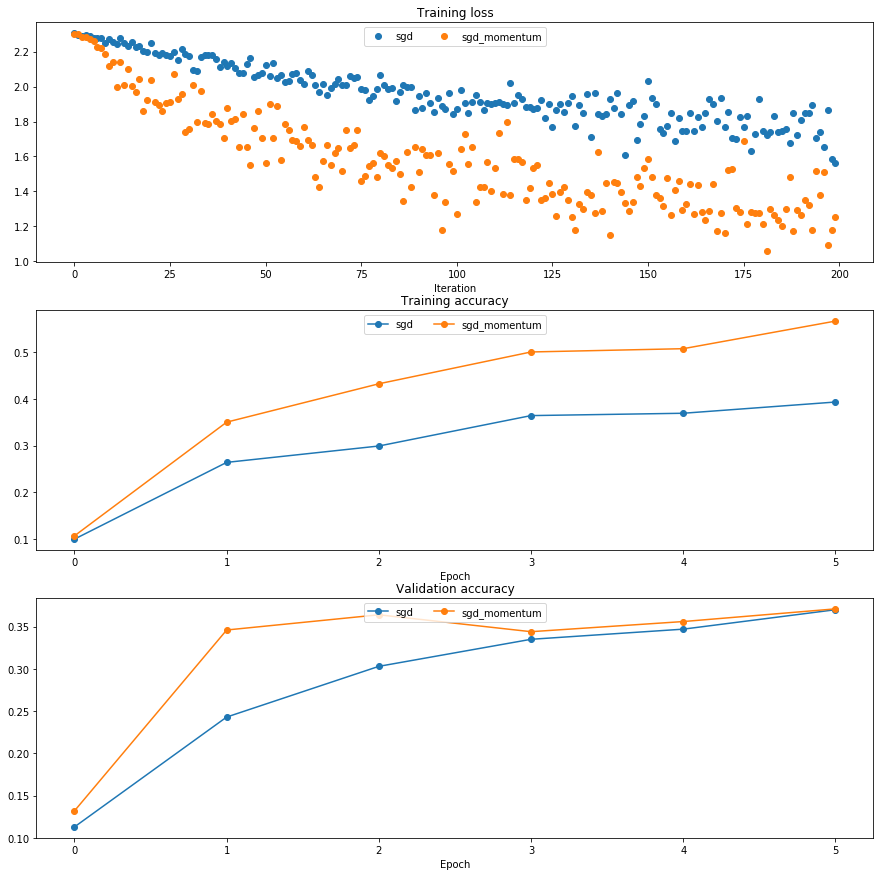

In [4]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  model = TwoLayerNet(hidden_dim=300)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 3e-4,
                  },
                  verbose=False)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

#Easy to see from below plots SGD+momentum is better than SGD.

# Adagrad and Adam
Adagrad [1] and Adam [2] are update rules that set per-parameter learning rates.

In the file `cs712/optim.py`, implement the Adagrad update rule in the `adagrad` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] John Duchi et.al, Adaptive Subgradient Methods for Online Learning and Stochastic Optimization

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [5]:
# Test Adagrad implementation; you should see errors less than 1e-7
from csl712.optim import adagrad

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = adagrad(w, dw, config=config)

expected_cache = np.asarray([  [0.96      , 0.91540166, 0.87634349, 0.84282548, 0.81484765],
                               [0.79240997, 0.77551247, 0.76415512, 0.75833795, 0.75806094],
                               [0.7633241 , 0.77412742, 0.79047091, 0.81235457, 0.83977839],
                               [0.87274238, 0.91124654, 0.95529086, 1.00487535, 1.06      ]
                           ])

expected_next_w = np.asarray([ [-0.39387628, -0.3416474 , -0.28945194, -0.23728959, -0.18515909],
                               [-0.1330581 , -0.08098318, -0.02892979,  0.02310755,  0.075135  ],
                               [ 0.12715916,  0.17918664,  0.23122376,  0.28327621,  0.33534884],
                               [ 0.38744551,  0.43956905,  0.49172129,  0.54390317,  0.59611486]
                            ])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  6.853331225411406e-08
cache error:  3.04502284936527e-09


In [6]:
# Test Adam implementation; you should see errors around 1e-7 or less
from csl712.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your Adagrad and Adam implementations, run the following to train a pair of two-layer-networks using these new update rules:

/home/mind/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


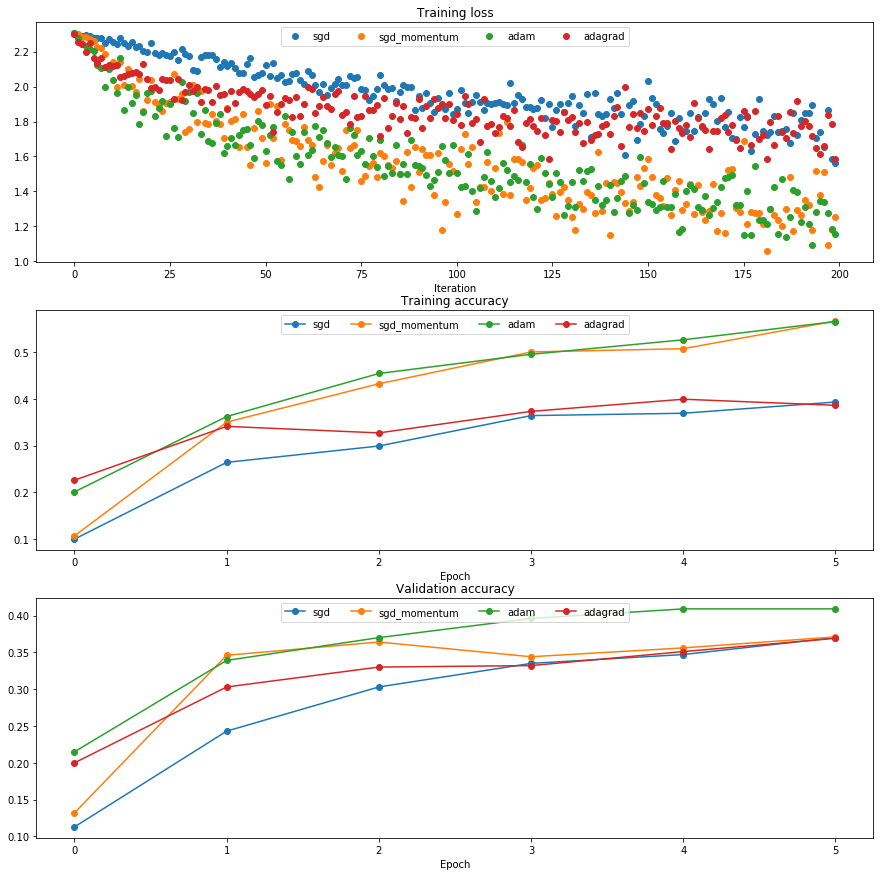

In [7]:
learning_rates = {'adagrad': 1e-4, 'adam': 1e-4}
for update_rule in ['adam', 'adagrad']:
  model = TwoLayerNet(hidden_dim=100)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=False)
  solvers[update_rule] = solver
  solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

From above we can see both `Adam` and `SGD+momentum` seems great. `Adagrad` is also okay but not so good in above case. `SGD` is worst of all. Hence the default will be mostly one of `Adam` or `SGD+momentum`. In this I mostly use `Adam` as default.

# Activation Functions and Pre-Processing (ReLU, Sigmoid)

In this we will experiment with both standardization of data and only mean subtracted data. Then for each activation function here namely ReLU, Sigmoid we will see which one gives better results. 5000 training examples are taken unlike whole to see the results

In [2]:
#Only mean subtracted data

mean_data = get_CIFAR10_data(num_training=5000)
for k, v in list(mean_data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (5000, 3, 32, 32))
('y_train: ', (5000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [3]:
#Std data, using deepcopy to take care of aliasing

import copy #for above reason

std_data = copy.deepcopy(mean_data)

std_image = np.std(std_data['X_train'], axis = 0 ) #get the standard deviation. It's already zero mean.

std_data['X_train'] /= std_image
std_data['X_val']   /= std_image
std_data['X_test']  /= std_image

In [4]:
# Store the data types in a dictionary to easy resuse later
pre_process_data = {}

pre_process_data['mean_only'] = mean_data
pre_process_data['standardization'] = std_data

# Experiment with Sigmoid

/home/mind/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


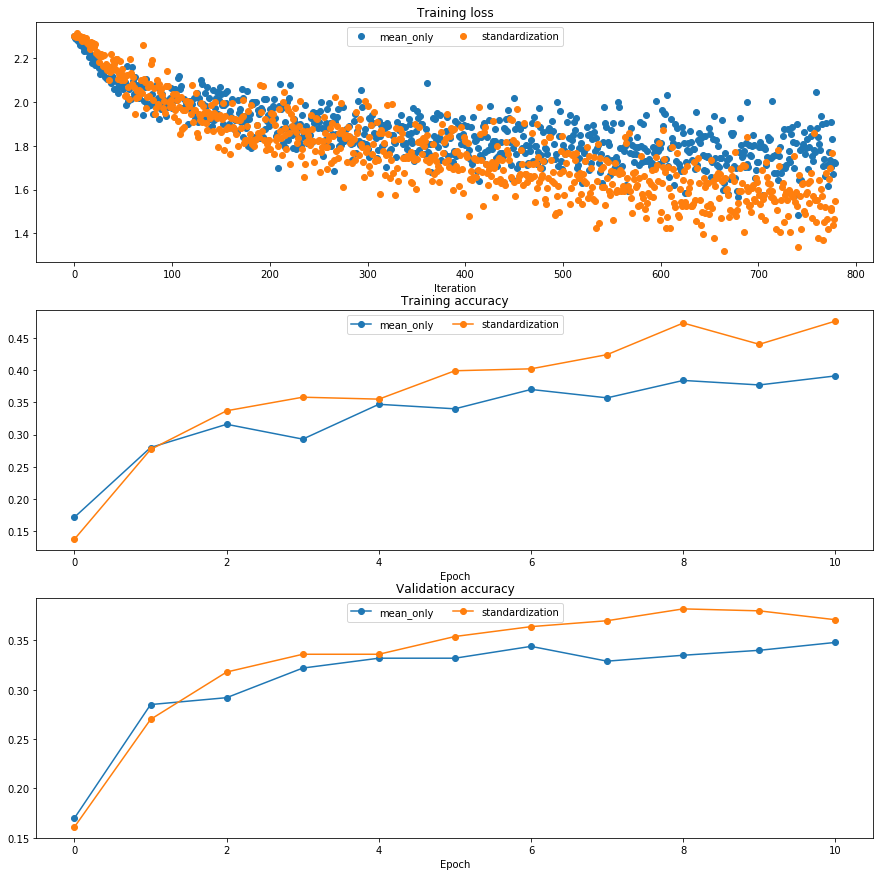

In [13]:
# Experiment with the sigmoid activation function varying just the data part and keep all remaining same

solvers = {}

for pre_processing in ['mean_only', 'standardization']:
  model = TwoLayerNet(hidden_dim=300, activation_fn = 3)

  solver = Solver(model, pre_process_data[pre_processing],
                  num_epochs=10, batch_size=64,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 2e-4,
                  },
                  verbose=False)
  solvers[pre_processing] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

#Easy to see from below plots 'mean only' worse than 'standardization'

# Experiment with ReLU

/home/mind/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


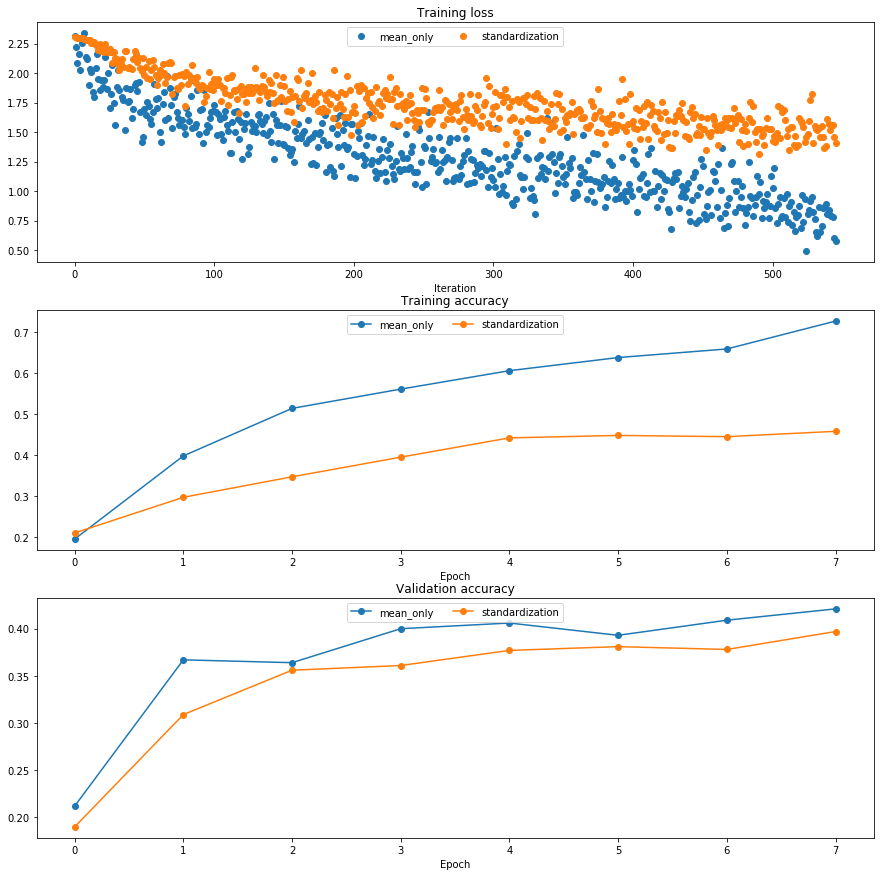

In [16]:
# Experiment with the ReLU activation function varying just the data part and keep all remaining same

solvers = {}

for pre_processing in ['mean_only', 'standardization']:
  model = TwoLayerNet(hidden_dim=300)

  solver = Solver(model, pre_process_data[pre_processing],
                  num_epochs=7, batch_size=64,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-4,
                  },
                  verbose=False)
  solvers[pre_processing] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

#Easy to see from below plots 'mean only' better than 'standardization'

Observation: From the above plots, we can see that for `Sigmoid` the `Standardized` data gave better results and for `ReLU` the `mean only` data i.e., only subtracting the mean gave better results. In case of `ReLU` the `mean only data` tended to overfit more than the `Standardized data` which says while training best model regularization has to be taken into account.

# Train a good model!
Train the best Two-layer-Network model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a Two-Layer net. 

In [8]:
#From the activation functions 'LeakyReLU' and from optimization routine 'Adam' is taken.
#Train the models for say 7 epochs and take the best model out of this, finally train this for more epochs.
#Fixed the reg to 0.5

best_model = None
best_val_acc = 0.0
best_hidden = None
################################################################################
# TODO: Train the best TwoLayerNet that you can on CIFAR-10. Store your best   #
#  model in the best_model variable.                                           #
################################################################################
for hidden in range(500,1001,100):
    model = TwoLayerNet(hidden_dim = hidden, reg = 0.5, activation_fn = 1) # LeakyReLU activation function.
    solver = Solver(model, data,update_rule='adam',optim_config={'learning_rate': 1e-4,},lr_decay=0.95,
                        num_epochs = 7, batch_size = 256, verbose = False)
    solver.train()
    
    print ("For " + str(hidden) + " hidden units, " + " best validation accuracy is: " + 
                str(solver.best_val_acc))
    
    if (best_val_acc < solver.best_val_acc):
        best_model = model
        best_val_acc = solver.best_val_acc
        best_hidden = hidden
        
print ("Best Validation accuracy for 7 epochs is: " + str(best_val_acc))
print ( "Best models Hidden units are: " + str(best_hidden))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

For 500 hidden units,  best validation accuracy is: 0.518
For 600 hidden units,  best validation accuracy is: 0.502
For 700 hidden units,  best validation accuracy is: 0.497
For 800 hidden units,  best validation accuracy is: 0.49
For 900 hidden units,  best validation accuracy is: 0.505
For 1000 hidden units,  best validation accuracy is: 0.491
Best Validation accuracy for 7 epochs is: 0.518
Best models Hidden units are: 500


In [9]:
#Train the best model from above for say 75 epochs

best_model = TwoLayerNet(hidden_dim = best_hidden, reg = 0.5, activation_fn = 1) 
solver = Solver(best_model, data,update_rule='adam', optim_config={'learning_rate': 1e-4,}, lr_decay=0.95,
                num_epochs = 75, batch_size = 256, verbose = False)
solver.train()
    
print ( "Best validation accuracy is: " +  str(solver.best_val_acc) )

Best validation accuracy is: 0.582


# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [10]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.582
Test set accuracy:  0.559


The model gave an accuracy of 55.9% on Test Dataset.

# References

All the code of this is reused and built on from this excellent [course](http://cs231n.stanford.edu/) [assignment](http://cs231n.github.io/assignments2017/assignment2/)